## Background

---

Critical path is essentially the bottleneck of a project. Typically, in Project Management, the various tasks and dependicies would first be analyzed and identified using Work Breakdown Structure (WBS) and Program Evaluation and Review Technique (PERT) before they are pipelined into Critical Path Analysis (CPA). In order to reduce the amount of time that a project takes, a manager should seek to shorten tasks along the critical path. One way of finding the critical path is by identifying the path with 0 slack (or float). Slack is a buffer where delay of task completion might not always affect the entire project, and it is calculated by subtracting the earliest finishing time (EF) from the latest finishing time (LF), or equivalently, subtracting the earliest start time (ES) from the latest start time (LS). You could read more about CPA in this [HBR article](https://hbr.org/1963/09/the-abcs-of-the-critical-path-method), but for now, let's consider the following example:

- Task A requires 3 days, and it can be started at any time
- Task B requires 5 days, and it can also be started at any time
- Task C requires 2 day, and it can only be started after both Task A and B are finished
- Task D requires 3 days, and it can start as soon as Task A is finished
- Task E requires 5 days, and it start as soon as Task C and D are finished

![Critical Path](p03_crit_path_01.png)

By calculating the slack of each task, we can quickly identify that the critical path is *B -> C -> E*, since there is 0 slack along these three tasks. However, this analysis gets much more complicated when managers are presented with more tasks for each project. At the same time, when certain tasks are compressed, the critical path might change. It seems mechanical going through the same process repeatedly to look for critical paths, and we want to find ways to eliminate duplicate work. Therefore, we are going to experiment with some packages that can be used to help project managers visualize the dependencies of different projects, identify the critical path, and find out how the path changes as completion time is reduced for different tasks.

## Finding and Visualizing Critical Path in Python

---

In this notebook, we are going to use two packages, `networkx` (dependent on `matplotlib`) and `criticalpath` (install using [pip](https://docs.python.org/3/installing/index.html) if you do not have these packages yet). We encourage you to read the documentations for [networkx](https://networkx.github.io/documentation/networkx-2.4/), a useful package for visualizing networks, as well as [criticalpath](https://pypi.org/project/criticalpath/), a simple developer package specifically designed to look for the critical path in a series of processes. First, let's import the packages:

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
from criticalpath import Node

### Set Up the Tasks and Visualize the Dependencies

Before we start looking for the critical path, we have to set up a task list as well as the sequence and dependencies of the tasks. We do so by creating two lists of tuples. In the task list, each tuple contains the name of the task and any attribute of the task; the attribute(s) should be presented in a dictionary. In the dependency list, each tuple contains two tasks, with the second one dependent on the first. After the task and dependency lists are setup, we could initialize a directed graph (with arrows) and import the two lists:

In [2]:
# set up the tasks:
tasks = [("A", {"Duration": 3}), 
         ("B", {"Duration": 5}), 
         ("C", {"Duration": 2}), 
         ("D", {"Duration": 3}), 
         ("E", {"Duration": 5})]

# set up the dependencies along all paths:
dependencies = [("A", "C"), 
                ("B", "C"), 
                ("A", "D"),
                ("C", "E"), 
                ("D", "E")]

# initialize (directed) graph
G = nx.DiGraph() 

# add tasks and dependencies (edges)
G.add_nodes_from(tasks)
G.add_edges_from(dependencies)

One thing to notice is that, by default, `networkx` randomly position the nodes every time it generates a plot. This is technically not a problem as long as the orders of the tasks remain the same; however, people usually want their graphs to be a little bit more predictable, and to make the graphs easier to understand the remember, it is a good idea to specify the (x, y) coordinates of the nodes (it might be helpful for you to draw it on a piece of paper first):

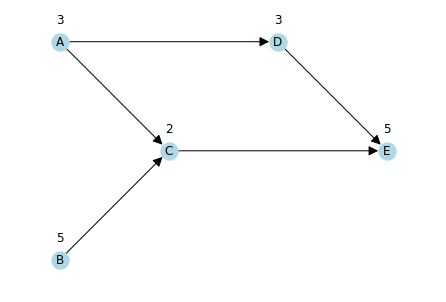

In [5]:
# set up the (arbitrary) positions of the tasks (nodes):
pos_nodes = {"A": (1, 3), 
             "B": (1, 1), 
             "C": (2, 2), 
             "D": (3, 3), 
             "E": (4, 2)}

# draw the nodes
nx.draw(G, with_labels=True, pos=pos_nodes, node_color='lightblue', arrowsize=20)


# set up the (arbitrary) positions of the durations labels (attributes):
pos_attrs = {node:(coord[0], coord[1] + 0.2) for node, coord in pos_nodes.items()}
attrs = nx.get_node_attributes(G, 'Duration')

# draw (write) the node attributes (duration)
nx.draw_networkx_labels(G, pos=pos_attrs, labels=attrs)


# set a little margin (padding) for the graph so the labels are not cut off
plt.margins(0.1)

### Searching for the Critical Path

Now that we have the network of tasks visualized (which will be helpful later when we want to draw the critical path), we can proceed to actually looking for the critical path. This is where the `criticalpath` package comes in handy. Intead of manually calculating the possible slack of each task, we can just load the tasks, their durations, and any dependencies into an `object` (project) using the `criticalpath` package:

In [6]:
# initialize a "project":
proj = Node('Project')

# load the tasks and their durations:
for t in tasks:
    proj.add(Node(t[0], duration=t[1]["Duration"]))

# load the dependencies (or sequence):
for d in dependencies:
    proj.link(d[0],d[1])

# update the "project":
proj.update_all()

Once we update the "project" with tasks and dependencies using the `update_all()` method, we can extract the critical path and the total project duration using the following commands:

In [54]:
# proj.get_critical_path() will return a list of nodes
# however, we want to store them as strings so that they can be easily used for visualization later
crit_path = [str(n) for n in proj.get_critical_path()]

# get the current duration of the project
proj_duration = proj.duration

print(f"The current critical path is: {crit_path}")
print(">"*50)
print(f"The current project duration is: {proj_duration} days")

The current critical path is: ['B', 'C', 'E']
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
The current project duration is: 12 days


### Visualize the Critical Path

A picture is worth a thousand words (most of the time), and it would be much faster for people to understand which tasks can be crunched and the impact of reducing these tasks through a visualized network. Therefore, we bring back the graph from above, but this time we layer on top our current critical path:

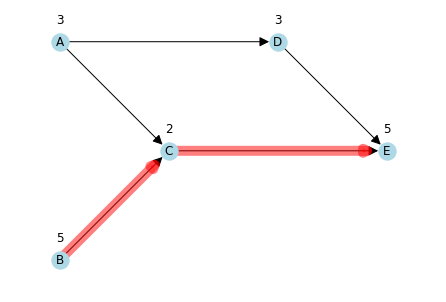

In [35]:
# create a list of edges using the current critical path list:
crit_edges = [(n, crit_path[i+1]) for i, n in enumerate(crit_path[:-1])]

# first, recreate the network visualization:
nx.draw(G, with_labels=True, pos=pos_nodes, node_color='lightblue', arrowsize=20)
nx.draw_networkx_labels(G, pos=pos_attrs, labels=attrs)

# now add the critical path as an additional layer on top of the original graph:
nx.draw_networkx_edges(G, pos=pos_nodes, edgelist=crit_edges, width=10, alpha=0.5, edge_color='r')

# again, leaving some margin so the labels are not cut off
plt.margins(0.1)

Looking for the critical path can easily become a hassle in a big project with ever changing timelines of various tasks. The `networkx` and `criticalpath` packages make it so much faster and easier to find and visualize the path that can use the most improvement. Now that you know the basics, we have created a challenge for you below so that you could apply these techniques to a more complicated problem by yourself. Don't forget to go back and read the documentations of the different packages if you want to explore different ways of solving this problem!

## Challenge: Create A Dynamic Tool

---

To be continued...

## Reference

---

https://hbr.org/1963/09/the-abcs-of-the-critical-path-method <br>
https://medium.com/@yujeshmalekushrestha/the-critical-path-analysis-in-project-management-94c75f77932f